In [11]:
import numpy as np
import pandas as pd
from typing import Any, cast, Dict

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate Datasets

Copies of the dataset, each with a different scaler applies, are generated and stored for usage in training.

In [24]:
from read_data import read_datasets
from data_cleaning import prep_dataframe

dep_var = "Log(Rmax)"
# dep_var = "Log(Efficiency)"
use_crossval = True

all_data = read_datasets()
combined_data = prep_dataframe(all_data, dep_var)


Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.200GHz' @ Earth Simulator, 2009
Unknown processor: 'NEC', full name: 'NEC  3.20GHz' @ Earth Simulator, 2009
Unknown processor: 'Xeon EM64T', full name: 'Xeon EM64T  3.60GHz' @ Thunderbird, 2006


In [25]:
from training import train_test_random, split_x_y
from data_cleaning import DataCleaner
from models import scalers

datasets = {}
cleaners = {}
for scaler_name, scaler in scalers.items():
    cleaner = DataCleaner(scaler, dep_var)
    data = cleaner.fit_transform(combined_data.copy())
    data = data.drop(columns="Date")

    if use_crossval:
        # Need holdout split, but not train test b/c cross val will do them
        non_holdout, holdout = train_test_random(data, 0.1)
        datasets[scaler_name] = split_x_y([non_holdout, holdout], dep_var)
        cleaners[scaler_name] = cleaner
    else:
        # Do splits for all data
        non_holdout, holdout = train_test_random(data, 0.1)
        train, test = train_test_random(non_holdout, 0.1)
        datasets[scaler_name] = split_x_y([train, test, holdout], dep_var)
        cleaners[scaler_name] = cleaner


Filtered duplicates to go from 10000 rows to 2476
Filtered duplicates to go from 10000 rows to 2476
Filtered duplicates to go from 10000 rows to 2476


In [26]:
from training import calc_stats
from tqdm.auto import tqdm
from sklearn.metrics import r2_score

from models import models
from kfold import cross_validate

cols = ["name", "scaler", "r2", "mae", "mape", "mse"]
if use_crossval:
    cols += ["cv_r2", "std", "min", "max", "best_estimator"]
    results = pd.DataFrame(columns=cols)
else:
    results = pd.DataFrame(columns=cols)

for model_name, model in tqdm(models.items()):
    tqdm.write(model_name)
    for scaler_name in scalers.keys():
        if use_crossval:
            [non_holdout, holdout] = datasets[scaler_name]
            (X, y) = non_holdout

            # Run cross validation
            r2, best_estimator = cross_validate(model, X, y, scoring=r2_score, cv=10)

            # Calc stats for holdout set using the best estimator
            pred_y = best_estimator.predict(holdout[0])
            result = calc_stats(holdout[1], pred_y, print_res=False)

            # Add in data specific to cross validation + name and scaler info
            result |= {
                "name": model_name,
                "scaler": scaler_name,
                "cv_r2": r2.mean(),
                "std": r2.std(),
                "min": r2.min(),
                "max": r2.max(),
                "best_estimator": best_estimator,
            }
        else:
            train, test, holdout = datasets[scaler_name]
            model.fit(train[0], train[1])

            pred_y = model.predict(test[0])
            result = calc_stats(test[1], pred_y, print_res=False)
            result = cast(Dict[str, Any], result)
            result["name"] = model_name
            result["scaler"] = scaler_name

        results = results.append(result, ignore_index=True)


  0%|          | 0/21 [00:00<?, ?it/s]

lr_1
knn_1
knn_2
knn_3
knn_4
knn_5
svr_1
svr_2
rf_1
rf_2
rf_3
gbt_1
gbt_2
gbt_3
gbt_4
gbt_5
mlp_1


/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/brendan-doney/Developer/CSGenome/ML-rewrite/.venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimize

dnn1_1
dnn2_1
xgb_1
lgbm_1


In [30]:
# Take only the maximum scaler config for each model
max_indices = results.groupby(["name"])["max"].idxmax()
maximums = results.loc[max_indices]
maximums.sort_values(by="max", ascending=False)


,name,scaler,r2,mae,mape,mse,cv_r2,std,min,max,best_estimator
57,xgb_1,Robust,0.928420,0.206141,0.033734,0.139328,0.955162,0.014224,0.922387,0.977495,"XGBRegressor(base_score=0.5, booster='gbtree',..."
24,rf_1,Robust,0.940335,0.204473,0.033762,0.116135,0.948349,0.015660,0.914610,0.973556,"(DecisionTreeRegressor(max_features='auto', ra..."
27,rf_2,Robust,0.942078,0.203398,0.033697,0.112742,0.948347,0.016442,0.911717,0.973096,"(DecisionTreeRegressor(max_features='auto', ra..."
45,gbt_5,Robust,0.949573,0.213038,0.035282,0.098155,0.953025,0.012689,0.928380,0.972881,([DecisionTreeRegressor(criterion='friedman_ms...
44,gbt_4,MinMax,0.940718,0.238555,0.039598,0.115389,0.946332,0.014531,0.920194,0.969755,([DecisionTreeRegressor(criterion='friedman_ms...
61,lgbm_1,Standard,0.944813,0.215295,0.035632,0.107420,0.944869,0.013669,0.912514,0.966422,LGBMRegressor()
51,dnn1_1,Robust,0.936750,0.187573,0.031674,0.123114,0.950605,0.013546,0.924442,0.966367,DNN1()
12,knn_4,Robust,0.909062,0.229493,0.037148,0.177007,0.933130,0.021599,0.886677,0.964496,"KNeighborsRegressor(p=1, weights='distance')"
41,gbt_3,MinMax,0.928225,0.264790,0.044122,0.139707,0.934166,0.015370,0.911562,0.961547,([DecisionTreeRegressor(criterion='friedman_ms...
9,knn_3,Robust,0.899686,0.249481,0.040426,0.195258,0.926942,0.023819,0.887063,0.959523,"KNeighborsRegressor(n_neighbors=7, weights='di..."


In [31]:
from preservation import save_model

for index, row in maximums.iterrows():
    name: str = row["name"]  # type: ignore
    best_model = row["best_estimator"]
    best_scaler = cleaners[row["scaler"]]  # type: ignore

    save_model(name, best_model, best_scaler, dep_var)


<class 'models.DNN1'>
INFO:tensorflow:Assets written to: ml/models/dnn1_1/rmax/assets
<class 'models.DNN2'>
INFO:tensorflow:Assets written to: ml/models/dnn2_1/rmax/assets
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_1/rmax.pkl
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_2/rmax.pkl
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_3/rmax.pkl
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_4/rmax.pkl
<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
Sklearn: Model written to ml/models/gbt_5/rmax.pkl
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Sklearn: Model written to ml/models/knn_1/rmax.pkl
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Sklearn: Model written to ml/models/knn_2/rmax.pkl
<class 'sklearn.neighbors._regression.KNeighborsRegressor'>
Sklear

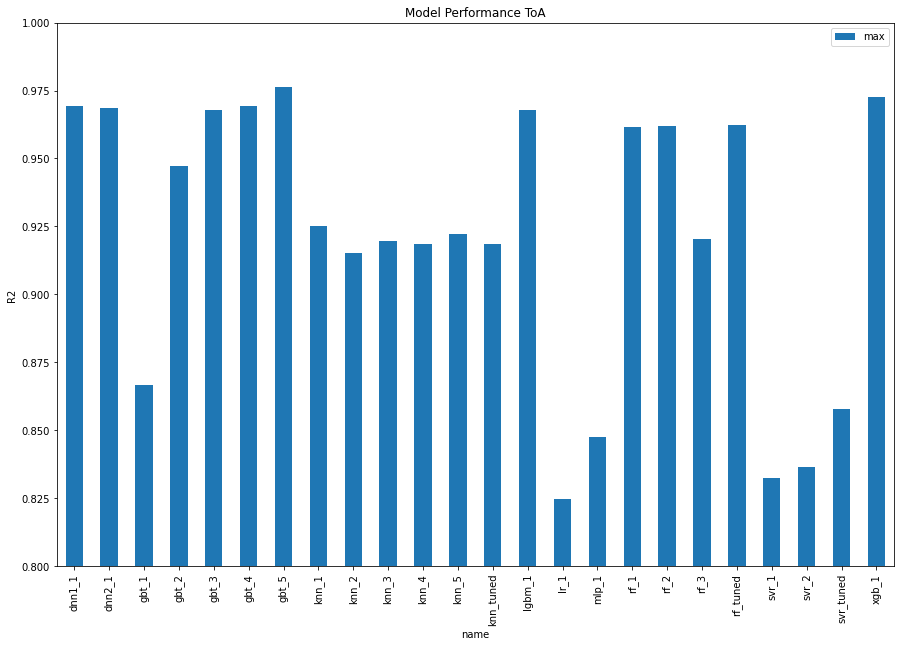

In [41]:
axis = maximums.plot.bar(x="name", y="max", figsize=(
    15, 10), ylabel="R2", ylim=(0.8, 1), title="Model Performance ToA")


In [42]:
from datetime import datetime
import pathlib

now = datetime.now()
dt_string = now.strftime(r"%m-%d-%YT%I-%M-%S%p")

all_identifier = f"all_results_toa_{dt_string}"
best_identifier = f"best_results_toa_{dt_string}"
out_dir = pathlib.Path("out")
all_csv_path = out_dir / (all_identifier + ".csv")
best_csv_path = out_dir / (best_identifier + ".csv")
img_path = out_dir / (best_identifier + ".png")

results.to_csv(all_csv_path)
maximums.to_csv(best_csv_path)
axis.figure.set_facecolor((1, 1, 1, 1))
axis.figure.savefig(img_path)
